In [1]:
from eda import *
from models_utils import *
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pygam import LinearGAM, s
from gradientBoosting import *
from mertonJumpDiffusion import *
from scipy.special import inv_boxcox
from scipy import stats
import matplotlib.dates as mdates
from math import sqrt
import warnings
from cycler import cycler


warnings.filterwarnings('ignore')

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

custom_colors = ["#948B80", "#625D56", "#312E2B", "#875C62", "#5F4045", "#B79DA1",
                "#417156", "#2E4F3C", "#6D7C73"]

# Train /Test split

Split the time seris into a train (85%) and a test (15%) part

In [2]:
currency='BTC-USD'

train_df, test_df = load_train_val_test_data(
    file_name='data/exchange_v2.csv', 
    currency=currency,
    sizes=(0.85, 0.15)
)


# Add a new column to each dataframe to indicate the dataset type
train_df['Dataset'] = 'Train'
#val_df['Dataset'] = 'Validation'
test_df['Dataset'] = 'Test'

# Concatenate the dataframes
combined_df = pd.concat([train_df,test_df])

# Create a single chart with a color encoding based on the dataset type
chart = alt.Chart(combined_df).mark_line(strokeWidth=0.8).encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('Close:Q', scale=alt.Scale(domain=[combined_df['Close'].min() - 0.05, combined_df['Close'].max() + 0.05])),
    color=alt.Color('Dataset:N', scale=alt.Scale(range=["#625D56", "#875C62", "#2E4F3C"]))
).properties(
    width=800,
    height=300,
    title=f"{currency} Exchange Rate: Train/Test Split"
)

chart.save('graphs/btcusd/a_train_validation_test_split.json')
chart

alt.Chart(...)

# Calculate the benchmark models

Naive models for comparision
- mean of the train series
- last value of the train series
- drift of the train series
- values of he last season (last 90 days) 

For a model to be considered useful it has to at least perform better then the benchmarking models

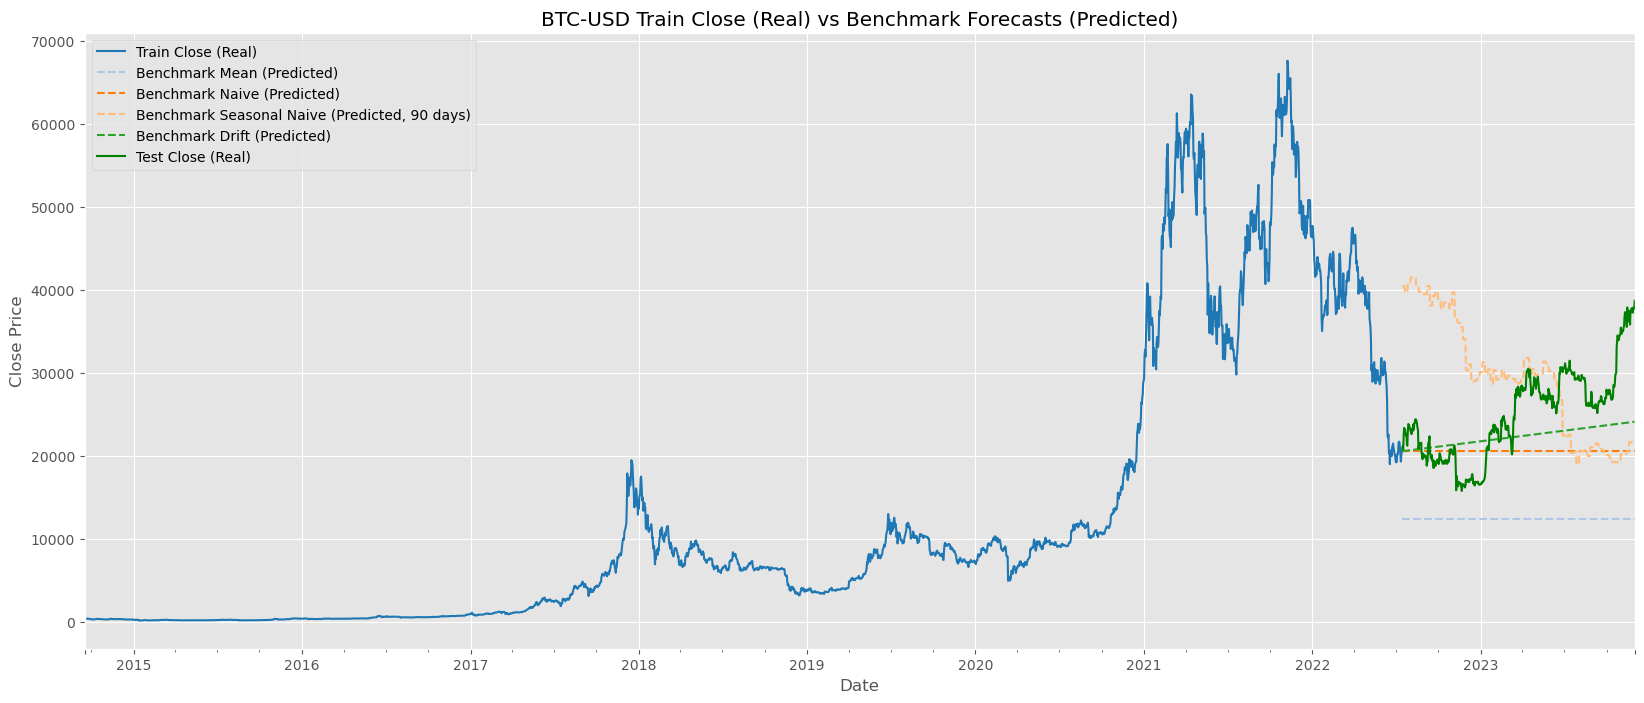

In [3]:
train_df, charts = preprocess(train_df, windows=(1, 3, 7, 30, 90, 365))
train_df, test_df = calc_benchmarks(train_df, test_df, seasonality=90)

In [4]:
benchmark_cols = [col for col in test_df.columns if "bench" in col]
benchmark_cols.append('Close')

# Reshape the DataFrame
long_df = test_df.melt(id_vars=['date'], value_vars=benchmark_cols, var_name='Benchmark', value_name='Value')

# Create the Altair Chart
chart = alt.Chart(long_df).mark_line(strokeWidth=0.6, point=False).encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('Value:Q', scale=alt.Scale(domain=[10000, 50000])),
    color=alt.Color('Benchmark:N', scale=alt.Scale(range=custom_colors))
).properties(
    width=800,
    height=300,
    title=f"{currency} Benchmark models against Test Dataset."
).configure_point(
    size=10
)

# Line chart for actual data
actual_line = alt.Chart(long_df).mark_area(
    line={"color": "#F6E8D6", "strokeWidth":0.3},
    color=alt.Gradient(
        gradient="linear",
        stops=[
            alt.GradientStop(color="white", offset=0),
            alt.GradientStop(color="#F6E8D6", offset=1),
        ],
        x1=1,
        x2=1,
        y1=1,
        y2=0,
    ),
    strokeDash=[1,1]
).encode(
    y=alt.Y('Close:Q', scale=alt.Scale(domain=[10000, 50000]))
)

# Save the chart
chart.save('graphs/btcusd/b_benchmarks.json')

chart

alt.Chart(...)

Text(0.5, 1.0, 'Benchmark Residuals Plot')

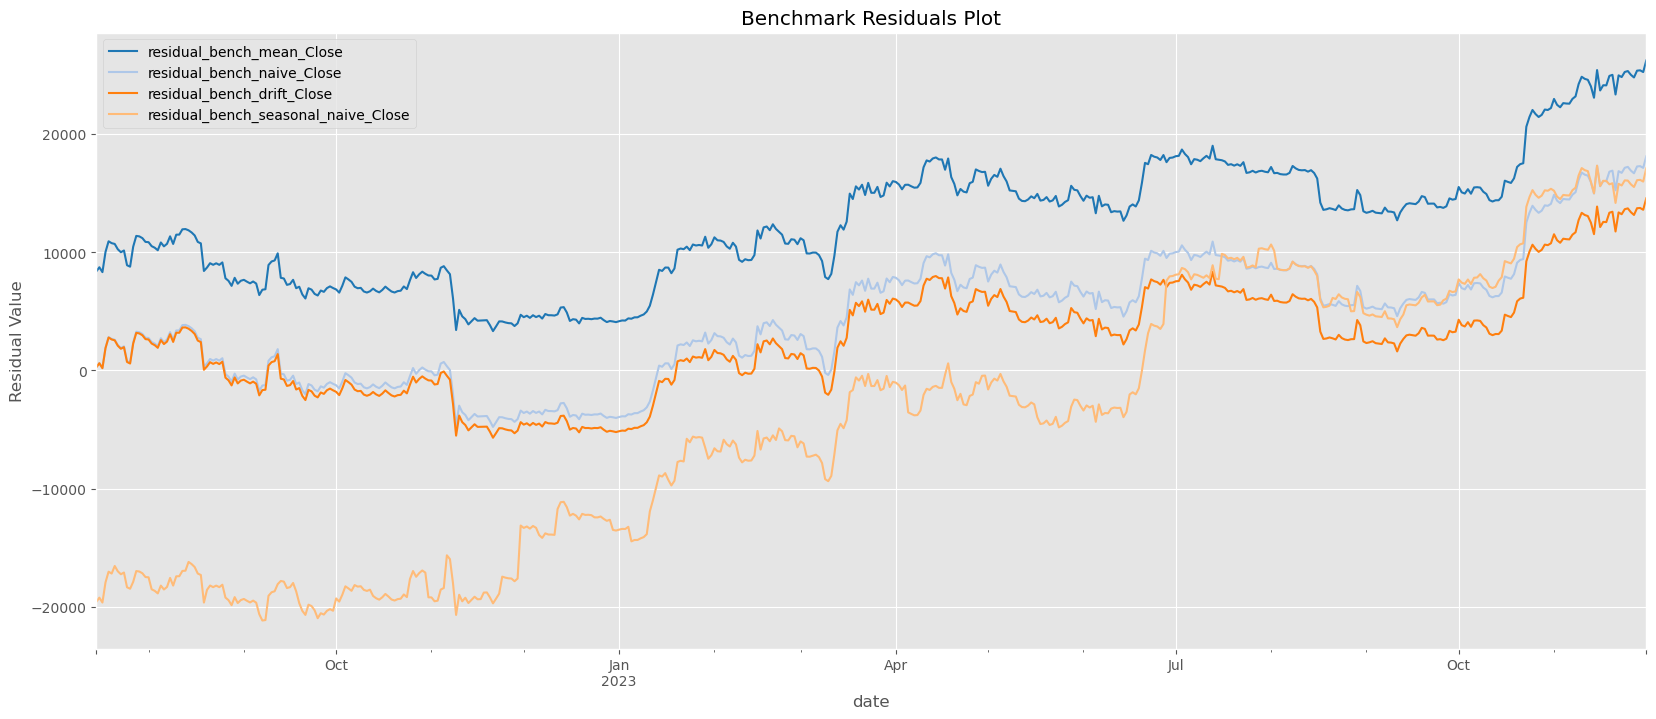

In [5]:
# List of benchmark columns
benchmark_cols = ['bench_mean_Close', 'bench_naive_Close', 
                  'bench_drift_Close', 'bench_seasonal_naive_Close']

# Calculate residuals and store in a new DataFrame
residuals_df = pd.DataFrame()

for col in benchmark_cols:
    residuals_df[f'residual_{col}'] = test_df['Close'] - test_df[col]
    
residuals_df.plot()

plt.ylabel("Residual Value")
plt.title("Benchmark Residuals Plot")

In [6]:
#calculate metrics for the benchmarking models
benchmark_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=benchmark_cols)
#benchmark_metrics.to_csv("graphs/btcusd/benchmark_metrics.csv")
benchmark_metrics.T

MAE           MSE          RMSE   
bench_mean_Close            12462.971646  1.841994e+08  13572.008284  \
bench_naive_Close            5562.778895  4.783143e+07   6916.026724   
bench_drift_Close            4259.440336  2.769475e+07   5262.579713   
bench_seasonal_naive_Close  10510.395003  1.502285e+08  12256.774267   

                                 MAPE        R2  
bench_mean_Close            47.570239 -5.379477  
bench_naive_Close           20.449146 -0.656571  
bench_drift_Close           16.324904  0.040833  
bench_seasonal_naive_Close  47.236010 -4.202945

# Other charts of interest 

In [7]:
for chart in charts:
    chart.display()

alt.Chart(...)

alt.LayerChart(...)

In [8]:
# Plot of first difference to show that it is stationary 

# Autocorrelations

of the train series

## Simple autocorrelation on Close

[]

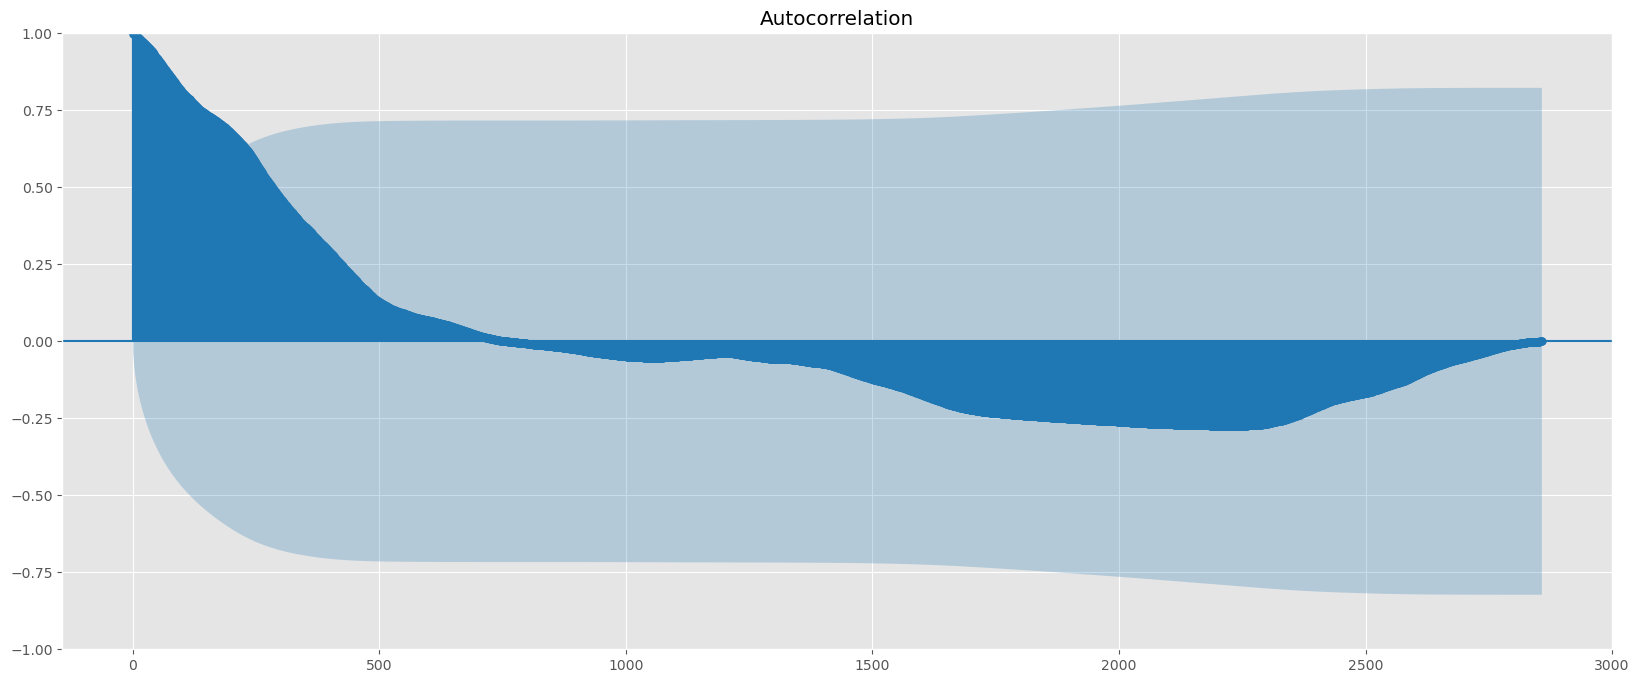

In [9]:
plot_acf((train_df['Close']).dropna(), lags=len(train_df)-1)
plt.plot()

No significant seasonal lags observed so it can be assumd that there is no clear seasonality in the series

## Autocorrelation on 1st order differenciation (1 day)


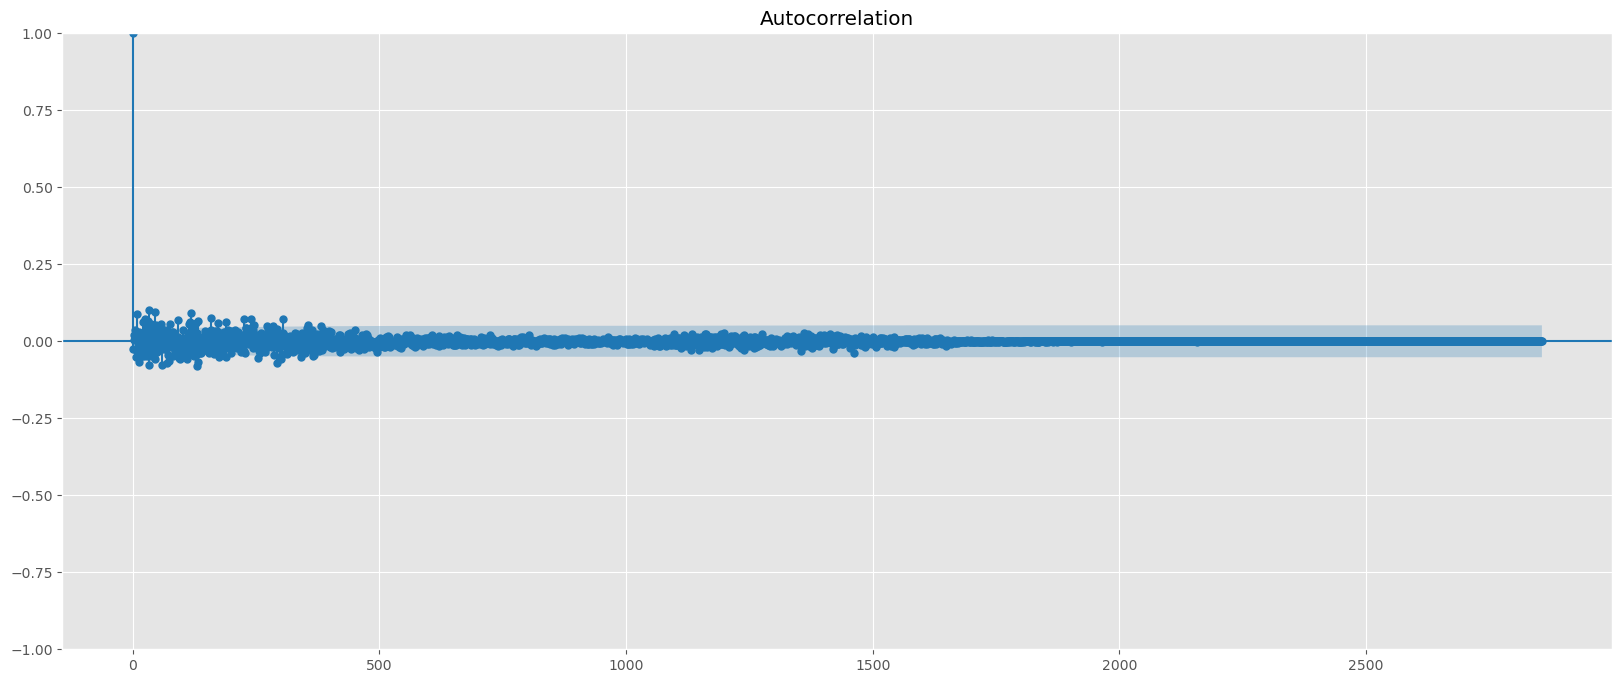

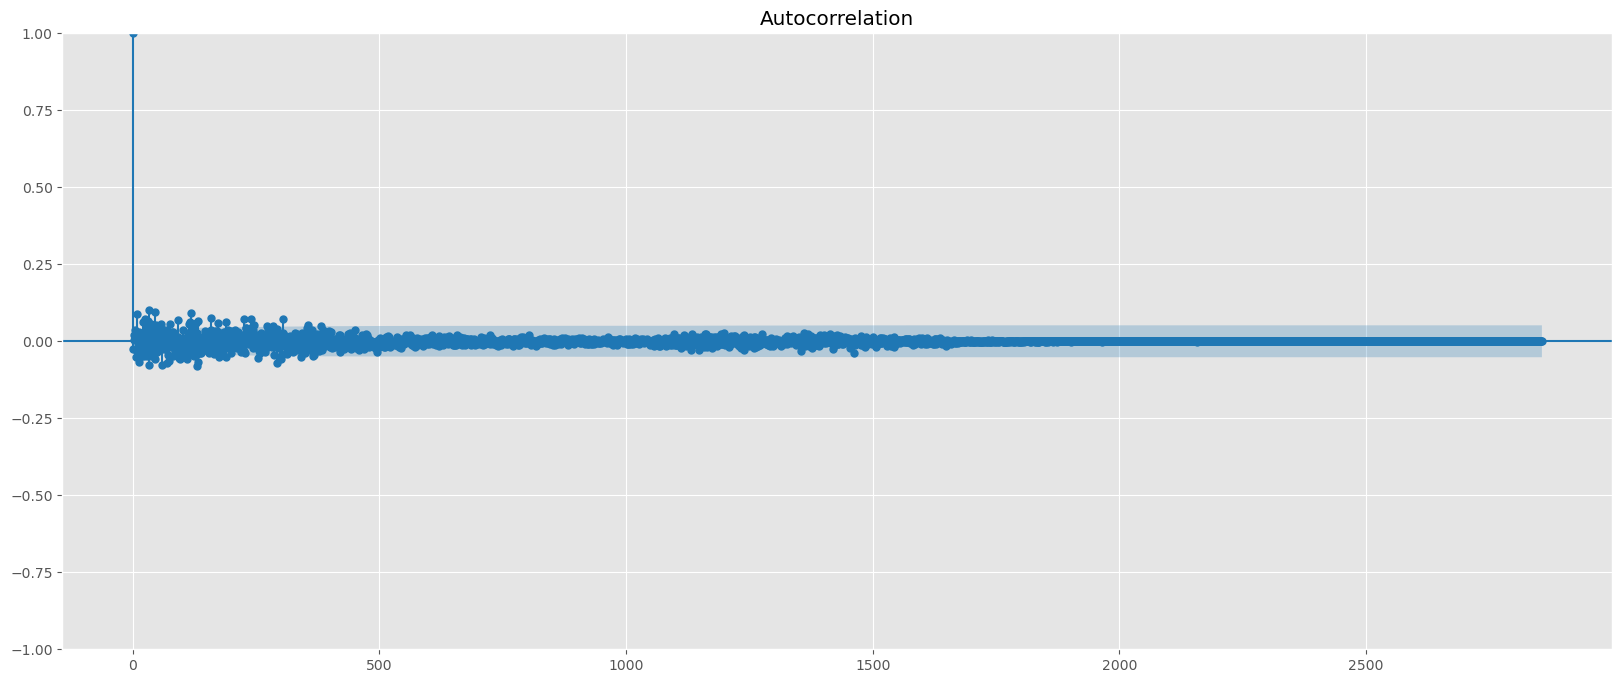

In [10]:
plot_acf((train_df['Close']-train_df['Close'].shift(1)).dropna(), lags=len(train_df)-2)

Autocorrelation indicates that first difference is (almost) stationary 

## Partial Autocorrelation at Close

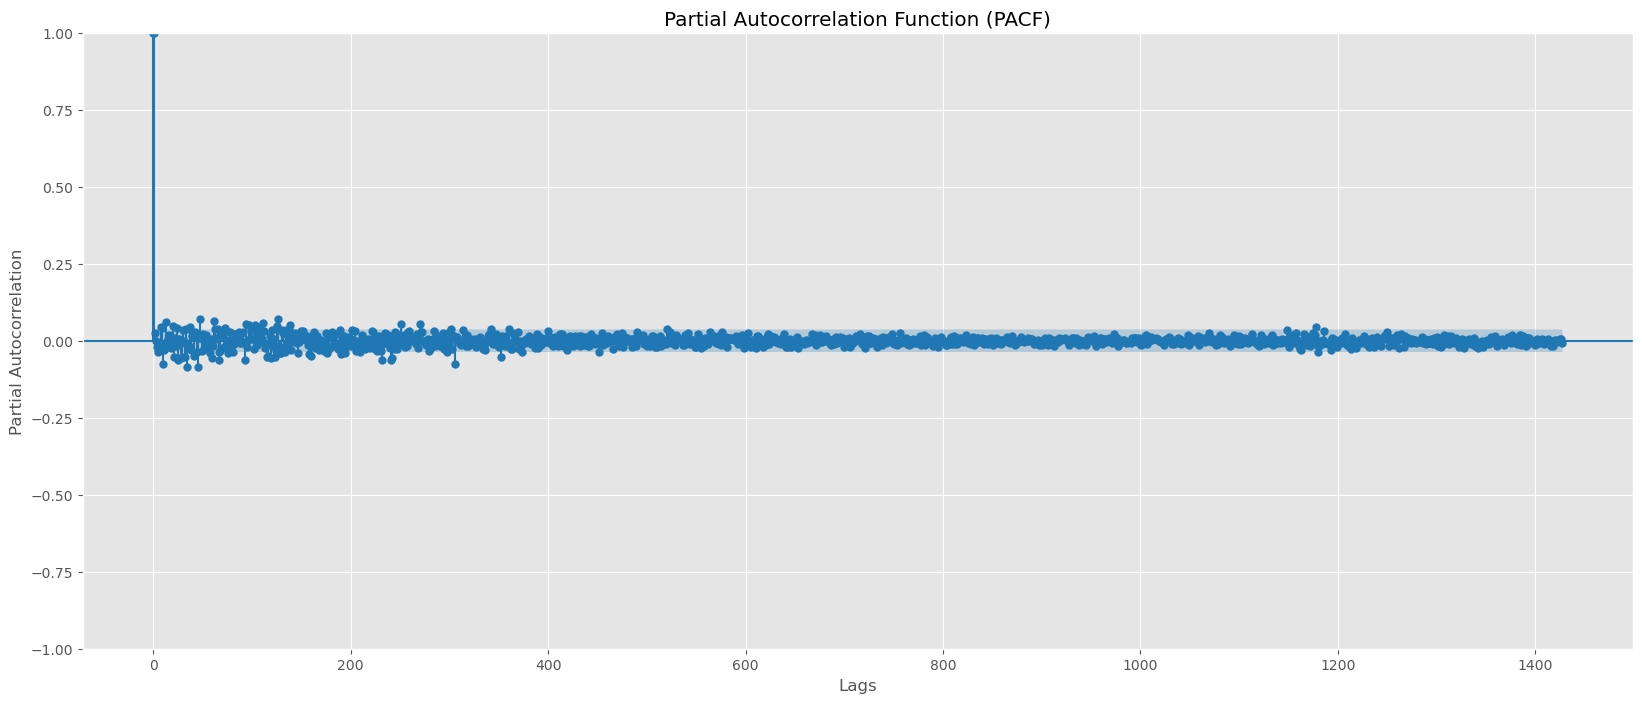

In [11]:
plot_pacf(train_df['Close'], lags=(len(train_df)/2)-2)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Transform the data

The bitcoin value has a lot of volatilitywhich can confuse/worsens performance of some models therfor perform Box Cox transform to make it more stable

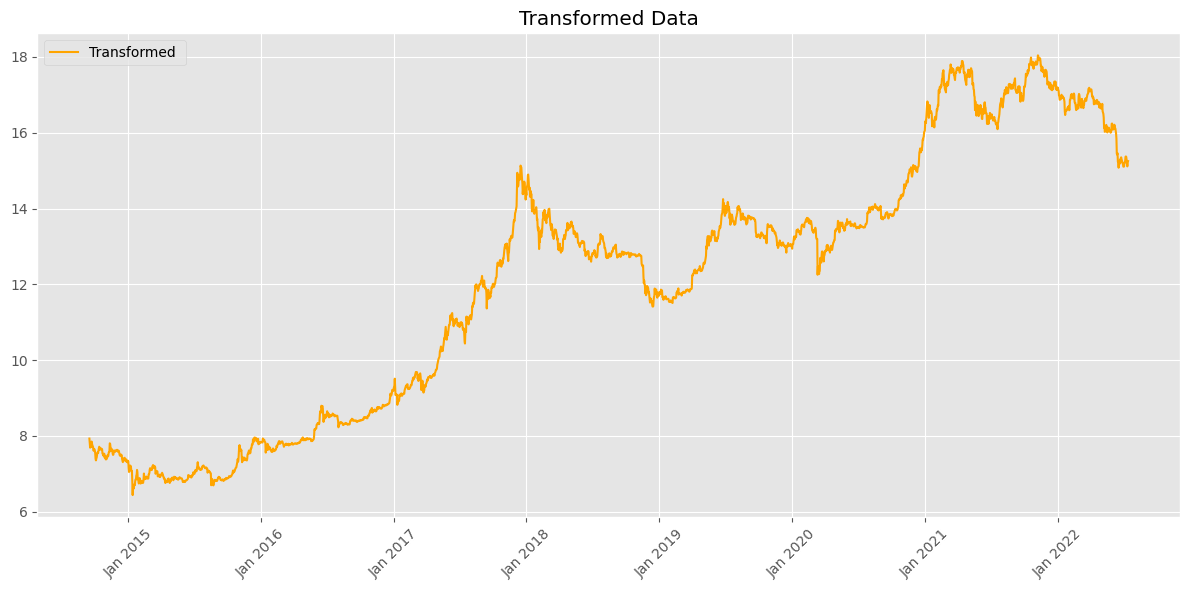

In [12]:
# # Apply box-cox transformation to the data
train_df['transf'], lambda_optimal = stats.boxcox(train_df['Close'])

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(train_df['date']), train_df['transf'], label='Transformed ', color='orange')
plt.title('Transformed Data')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
#return the inverse of the transformation
def inverse_bocxcx(predictions, lambda_optimal):
    predictions = inv_boxcox(predictions, lambda_optimal)
    
    return predictions

# Models

## ARIMA (AR, MA, ARMA, AND ARIMA)

In [14]:
def create_arima_model(df, ar_order=1, i_order=0, ma_order=1, feature='transf', transformed = False):
    df_copy = df.copy()
    model_fit = ARIMA(df_copy[feature], order=(ar_order, i_order, ma_order)).fit()
    start_point = max((ar_order, ma_order, i_order))
    predictions = model_fit.predict(start=start_point, end=len(df_copy)-1, dynamic=False)
    
    #reverse transformation for the predictions
    if transformed:
        predictions = inv_boxcox(predictions, lambda_optimal)
    
    # Reset indices to align the data
    df_copy = df_copy.reset_index(drop=True)
    predictions_reset = predictions.reset_index(drop=True)
    
    # Restore the original index
    df_copy.index = df.index
    predictions_reset.index = predictions.index
    
    df_copy[f'arima{ar_order}_{i_order}_{ma_order}_prediction'] = predictions
    
    return df_copy, model_fit, predictions_reset

In [15]:
def arima_forecast(df,model_fit):
    df_copy = df.copy()
    predictions = model_fit.forecast(steps=len(df_copy))
    predictions = inv_boxcox(predictions, lambda_optimal)
    
    df_copy[f'arima{ar_order}_{i_order}_{ma_order}_prediction'] = predictions
    
    return df_copy, predictions

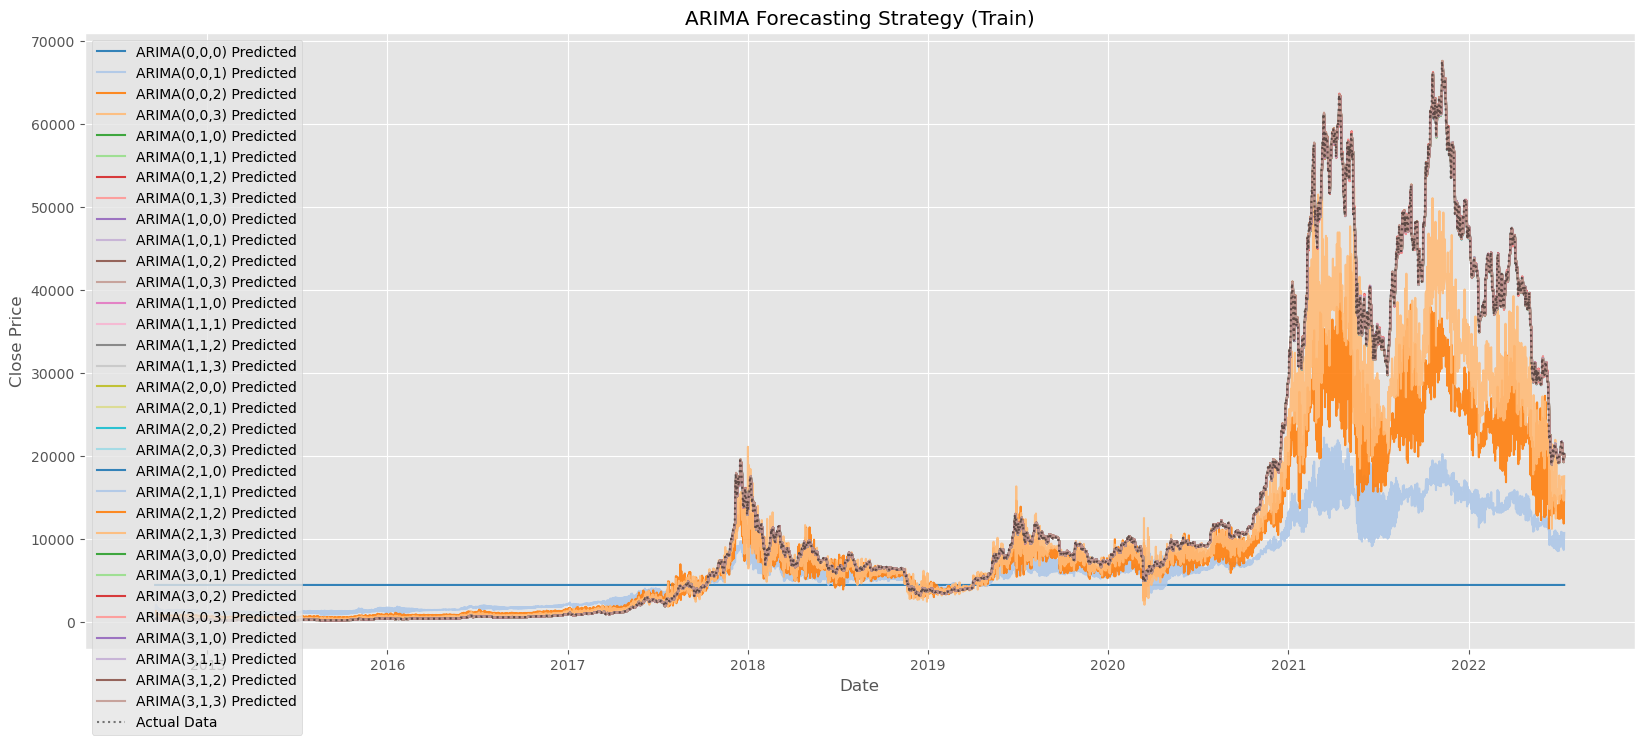

In [16]:
models = []
# Different combinations of AR and MA orders
arima_combinations = [(ar, i, ma) for ar in range(0,4) for i in [0,1] for ma in range(0,4)] 


for ar_order, i_order, ma_order in arima_combinations:
    train_df, model_arima, predictions_arima = create_arima_model(train_df, ar_order=ar_order, i_order=i_order, ma_order=ma_order, feature='transf', transformed = True)

    # Calculate the starting index for plotting
    start_index_for_plot = max((ar_order, ma_order, i_order))

    #plot model
    plt.plot(train_df.index[start_index_for_plot:], predictions_arima, label=f'ARIMA({ar_order},{i_order},{ma_order}) Predicted', alpha=0.9)
    models.append(model_arima)

plt.plot(train_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'ARIMA Forecasting Strategy (Train)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

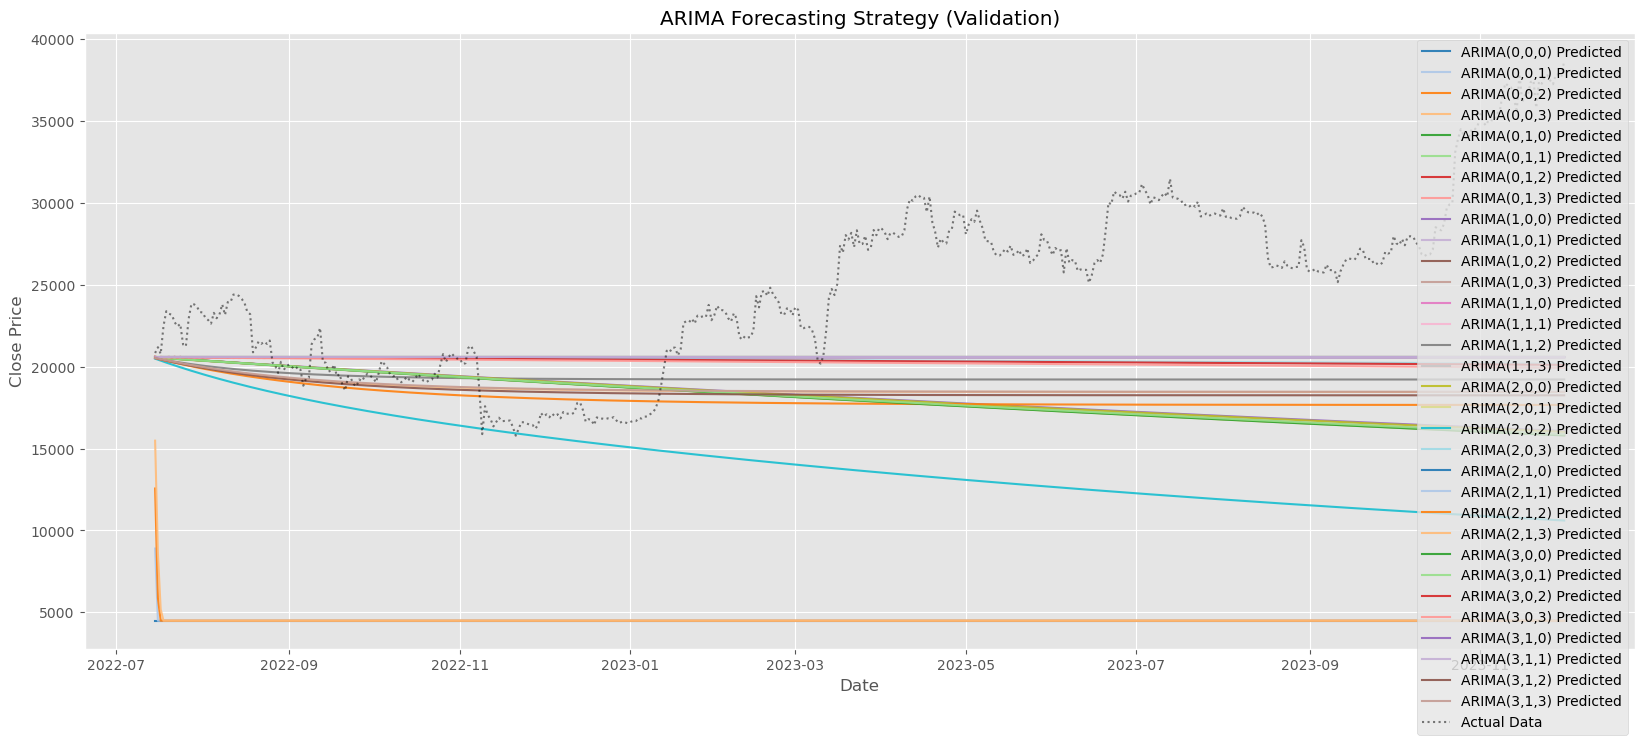

In [17]:
#get and plot predictions for the test dataset
for (ar_order, i_order, ma_order), model in zip(arima_combinations, models):
    test_df,predictions_arima = arima_forecast(test_df,model_fit=model)
    
    plt.plot(test_df.index, predictions_arima, label=f'ARIMA({ar_order},{i_order},{ma_order}) Predicted', alpha=0.9)

plt.plot(test_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'ARIMA Forecasting Strategy (Validation)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [18]:
test_df.head()

date          Open          High           Low         Close   
date                                                                            
2022-07-15 2022-07-15  20573.156250  21138.244141  20397.000000  20836.328125  \
2022-07-16 2022-07-16  20834.103516  21514.404297  20518.898438  21190.316406   
2022-07-17 2022-07-17  21195.041016  21600.640625  20778.179688  20779.343750   
2022-07-18 2022-07-18  20781.912109  22633.033203  20781.912109  22485.689453   
2022-07-19 2022-07-19  22467.849609  23666.962891  21683.406250  23389.433594   

               Adj Close       Volume currency Dataset  bench_mean_Close  ...   
date                                                                      ...   
2022-07-15  20836.328125  25905575359  BTC-USD    Test      12460.989965  ...  \
2022-07-16  21190.316406  24302954056  BTC-USD    Test      12460.989965  ...   
2022-07-17  20779.343750  22927802083  BTC-USD    Test      12460.989965  ...   
2022-07-18  22485.689453  39974475562  BTC-USD    Test      12460.989965  ...   
2022-07-19  23389.433594  48765202697  BTC-USD    Test      12460.989965  ...   

            arima2_1_2_prediction  arima2_1_3_prediction   
date                                                       
2022-07-15           20531.596109           20528.722562  \
2022-07-16           20486.258400           20481.071125   
2022-07-17           20445.781483           20450.122354   
2022-07-18           20403.685787           20405.426706   
2022-07-19           20363.479306           20374.703189   

            arima3_0_0_prediction  arima3_0_1_prediction   
date                                                       
2022-07-15           20566.613894           20564.990634  \
2022-07-16           20561.086272           20553.719937   
2022-07-17           20549.358723           20542.195015   
2022-07-18           20537.729958           20530.728256   
2022-07-19           20526.003609           20519.253914   

            arima3_0_2_prediction  arima3_0_3_prediction   
date                                                       
2022-07-15           20612.152536           20585.938679  \
2022-07-16           20576.472943           20554.168086   
2022-07-17           20598.772149           20581.409833   
2022-07-18           20587.570671           20556.554289   
2022-07-19           20583.643220           20571.613173   

            arima3_1_0_prediction  arima3_1_1_prediction   
date                                                       
2022-07-15           20569.308306           20569.173679  \
2022-07-16           20588.862888           20588.639740   
2022-07-17           20593.602542           20593.513613   
2022-07-18           20593.844464           20593.802695   
2022-07-19           20594.202605           20594.161587   

            arima3_1_2_prediction  arima3_1_3_prediction  
date                                                      
2022-07-15           20527.906838           20532.080608  
2022-07-16           20479.487675           20497.135133  
2022-07-17           20446.841820           20456.542766  
2022-07-18           20401.187557           20423.522573  
2022-07-19           20368.693412           20386.274999  

[5 rows x 45 columns]

In [19]:
#get metrics of the quality of the forecast
arima_cols = [f'arima{ar}_{i}_{ma}_prediction' for ar,i, ma in arima_combinations]
arima_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=arima_cols)
arima_metrics.T

MAE           MSE          RMSE       MAPE   
arima0_0_0_prediction  20436.867976  4.465393e+08  21131.476979  81.120501  \
arima0_0_1_prediction  20428.675131  4.463143e+08  21126.151500  81.080864   
arima0_0_2_prediction  20419.391183  4.461092e+08  21121.296763  81.036094   
arima0_0_3_prediction  20407.404091  4.458591e+08  21115.376733  80.978646   
arima0_1_0_prediction   5562.778895  4.783143e+07   6916.026724  20.449146   
arima0_1_1_prediction   5566.296820  4.789514e+07   6920.631702  20.458980   
arima0_1_2_prediction   5555.576444  4.770107e+07   6906.596149  20.429039   
arima0_1_3_prediction   5552.128618  4.763819e+07   6902.042687  20.419486   
arima1_0_0_prediction   7400.316717  8.730744e+07   9343.844789  26.429942   
arima1_0_1_prediction   7486.324561  8.946254e+07   9458.464171  26.711287   
arima1_0_2_prediction   7500.888929  8.984577e+07   9478.700756  26.761044   
arima1_0_3_prediction   7507.247109  9.001069e+07   9487.396310  26.782653   
arima1_1_0_prediction   5566.181707  4.789305e+07   6920.480595  20.458659   
arima1_1_1_prediction   5564.490768  4.786240e+07   6918.265572  20.453934   
arima1_1_2_prediction   6247.337040  6.099576e+07   7809.978170  22.484260   
arima1_1_3_prediction   5552.006300  4.763591e+07   6901.877103  20.419154   
arima2_0_0_prediction   7422.397207  8.785621e+07   9373.164325  26.501579   
arima2_0_1_prediction   7516.103734  9.022535e+07   9498.702588  26.810101   
arima2_0_2_prediction  10767.892049  1.719593e+08  13113.326549  38.773335   
arima2_0_3_prediction   5706.566770  5.046171e+07   7103.640864  20.916991   
arima2_1_0_prediction   5555.834507  4.770574e+07   6906.934289  20.429758   
arima2_1_1_prediction   5558.658884  4.775253e+07   6910.320290  20.438141   
arima2_1_2_prediction   7167.186111  7.937735e+07   8909.396830  25.595323   
arima2_1_3_prediction   6698.928145  6.966355e+07   8346.469509  23.996005   
arima3_0_0_prediction   7515.524238  9.021611e+07   9498.215951  26.808924   
arima3_0_1_prediction   7483.086861  8.939019e+07   9454.638664  26.701839   
arima3_0_2_prediction   5734.649603  5.098640e+07   7140.476468  21.007942   
arima3_0_3_prediction   5806.214910  5.232786e+07   7233.799987  21.235478   
arima3_1_0_prediction   5551.118261  4.761991e+07   6900.717792  20.416673   
arima3_1_1_prediction   5551.135243  4.762020e+07   6900.739054  20.416722   
arima3_1_2_prediction   6821.893599  7.211608e+07   8492.118618  24.415253   
arima3_1_3_prediction   6686.893308  6.950918e+07   8337.216857  23.950680   

                              R2  
arima0_0_0_prediction -14.465236  
arima0_0_1_prediction -14.457442  
arima0_0_2_prediction -14.450339  
arima0_0_3_prediction -14.441679  
arima0_1_0_prediction  -0.656571  
arima0_1_1_prediction  -0.658778  
arima0_1_2_prediction  -0.652057  
arima0_1_3_prediction  -0.649879  
arima1_0_0_prediction  -2.023765  
arima1_0_1_prediction  -2.098404  
arima1_0_2_prediction  -2.111677  
arima1_0_3_prediction  -2.117389  
arima1_1_0_prediction  -0.658706  
arima1_1_1_prediction  -0.657644  
arima1_1_2_prediction  -1.112499  
arima1_1_3_prediction  -0.649800  
arima2_0_0_prediction  -2.042771  
arima2_0_1_prediction  -2.124823  
arima2_0_2_prediction  -4.955560  
arima2_0_3_prediction  -0.747668  
arima2_1_0_prediction  -0.652219  
arima2_1_1_prediction  -0.653839  
arima2_1_2_prediction  -1.749119  
arima2_1_3_prediction  -1.412695  
arima3_0_0_prediction  -2.124503  
arima3_0_1_prediction  -2.095899  
arima3_0_2_prediction  -0.765840  
arima3_0_3_prediction  -0.812299  
arima3_1_0_prediction  -0.649246  
arima3_1_1_prediction  -0.649256  
arima3_1_2_prediction  -1.497635  
arima3_1_3_prediction  -1.407349

## ARIMAX

In [20]:
# Fit ARIMAX model
def train_and_plot_arima(df, orders, exg=None):
    models = []
    # Plot the original dataset once
    plt.plot(df, label="Original Dataset", color='black', alpha=0.6, linewidth=2)
    
    # Loop through each combination and plot the fitted values
    for ar_order, i_order, ma_order in arima_combinations:

        if exg is not None:
            #print("ARIMAX")
            model_fit = sm.tsa.SARIMAX(df, 
                                       exog=exg, 
                                       order=(ar_order, i_order, ma_order), 
                                       seasonal_order=(0, 0, 0, 0)).fit()
        else:    
            model_fit = ARIMA(df, order=(ar_order, i_order, ma_order)).fit()
            
        plt.plot(model_fit.fittedvalues, label=f'ARIMA({ar_order},{i_order},{ma_order})', alpha=0.9)
    
        # Save the model if you need it later
        models.append((model_fit, (ar_order, i_order, ma_order)))
    
    # Add legend and grid to the plot
    plt.legend()
    plt.grid(True)
    
    # Set the title and labels
    plt.title('Fitted Values of ARIMA Models')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    
    # Finally, show the plot
    plt.show()

    return models

#select best model based on AIC
def select_model(models):
    aic = models[0][0].aic
    model_fit = models[0][0]
    order = models[0][1]
    for model in models:
        if model[0].aic < aic:
            aic = model[0].aic
            model_fit = model[0]
            order = model[1]
            
    return model_fit

In [21]:
def forecast_and_plot(model_fit, df, test_df, transformed=False, lambda_optimal=None, exg=None):
    if exg is None:
        predictions = model_fit.forecast(steps=len(test_df['Close']))
    else:
        predictions = model_fit.forecast(steps=len(test_df['Close']), exog=exg)
    if transformed:
        predictions = inv_boxcox(predictions, lambda_optimal)
    
    # The index of 'predictions' should align with the index of 'test_df'
    predictions.index = test_df.index
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test_df["Close"], predictions))
    print('Test RMSE: %.3f' % rmse)
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(df["Close"], label='Training Data')
    
    # Plot predicted values
    plt.plot(predictions, color='blue', label='Predicted Test Data')
    
    # Plot actual test values
    plt.plot(test_df["Close"], color='green', label='Actual Test Data')
    
    plt.title('Train, Predicted Test, and Actual Test Data')
    plt.legend()
    
    plt.show()
    
    return predictions

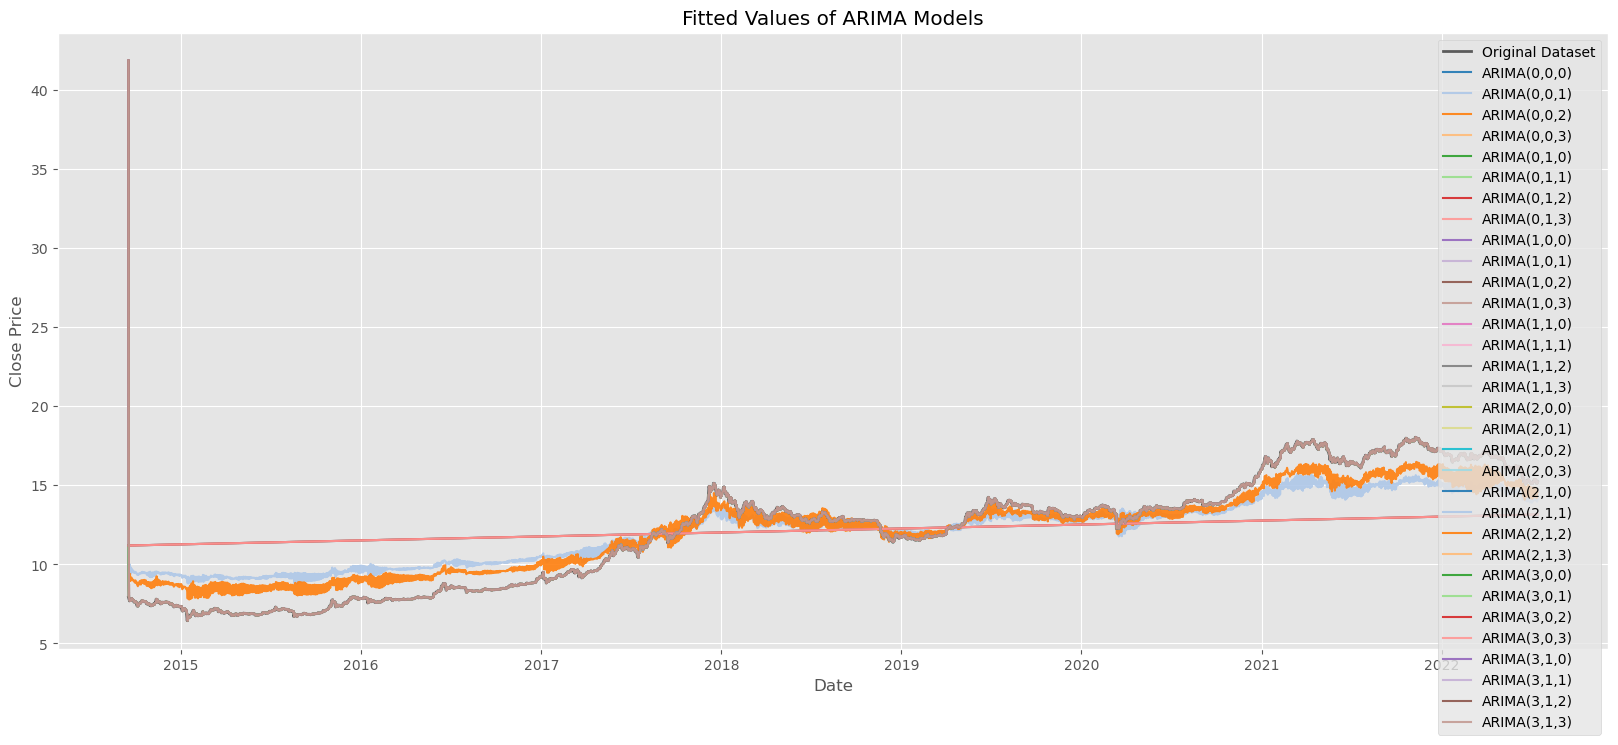

In [22]:
# Train ARIMAX
arima_combinations = [(ar, i, ma) for ar in range(0,4) for i in [0,1] for ma in range(0,4)]  # Different combinations of AR and MA orders
train_df['epoch'] = (train_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
models = train_and_plot_arima(train_df['transf'], arima_combinations, exg=train_df['epoch'])

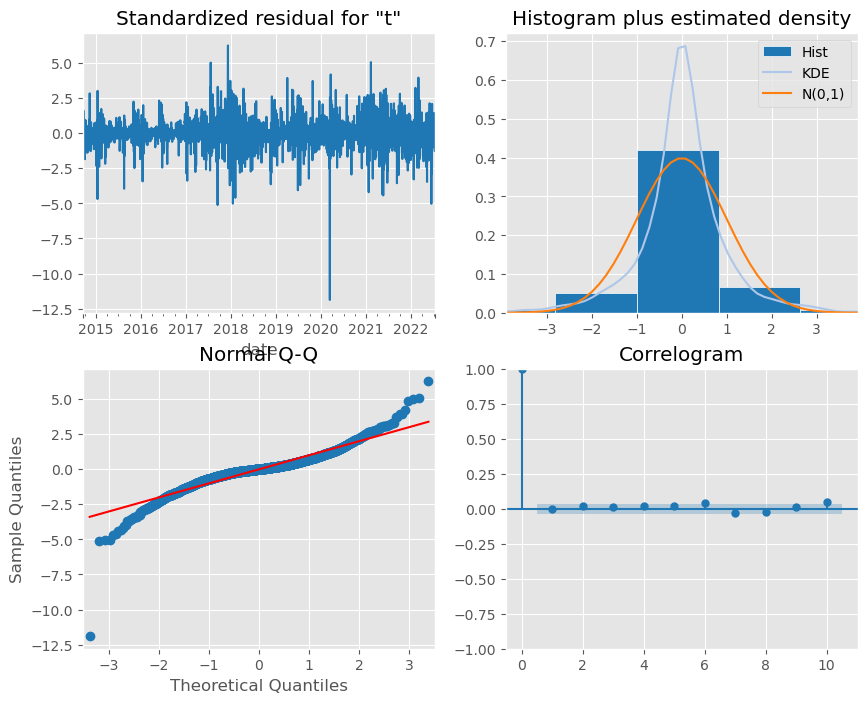

In [23]:
model_fit = select_model(models)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

Test RMSE: 4195.072


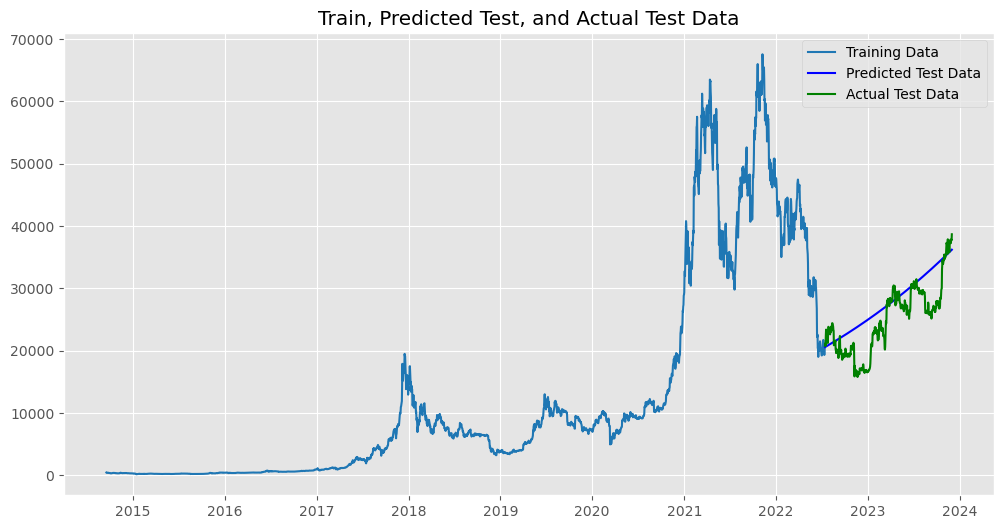

In [24]:
test_df['epoch'] = (test_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
predictions = forecast_and_plot(model_fit, train_df, test_df, transformed=True, lambda_optimal=lambda_optimal, exg=test_df['epoch'])

In [25]:
test_df['arimax_prediction'] = predictions
test_df.head()

date          Open          High           Low         Close   
date                                                                            
2022-07-15 2022-07-15  20573.156250  21138.244141  20397.000000  20836.328125  \
2022-07-16 2022-07-16  20834.103516  21514.404297  20518.898438  21190.316406   
2022-07-17 2022-07-17  21195.041016  21600.640625  20778.179688  20779.343750   
2022-07-18 2022-07-18  20781.912109  22633.033203  20781.912109  22485.689453   
2022-07-19 2022-07-19  22467.849609  23666.962891  21683.406250  23389.433594   

               Adj Close       Volume currency Dataset  bench_mean_Close  ...   
date                                                                      ...   
2022-07-15  20836.328125  25905575359  BTC-USD    Test      12460.989965  ...  \
2022-07-16  21190.316406  24302954056  BTC-USD    Test      12460.989965  ...   
2022-07-17  20779.343750  22927802083  BTC-USD    Test      12460.989965  ...   
2022-07-18  22485.689453  39974475562  BTC-USD    Test      12460.989965  ...   
2022-07-19  23389.433594  48765202697  BTC-USD    Test      12460.989965  ...   

            arima3_0_0_prediction  arima3_0_1_prediction   
date                                                       
2022-07-15           20566.613894           20564.990634  \
2022-07-16           20561.086272           20553.719937   
2022-07-17           20549.358723           20542.195015   
2022-07-18           20537.729958           20530.728256   
2022-07-19           20526.003609           20519.253914   

            arima3_0_2_prediction  arima3_0_3_prediction   
date                                                       
2022-07-15           20612.152536           20585.938679  \
2022-07-16           20576.472943           20554.168086   
2022-07-17           20598.772149           20581.409833   
2022-07-18           20587.570671           20556.554289   
2022-07-19           20583.643220           20571.613173   

            arima3_1_0_prediction  arima3_1_1_prediction   
date                                                       
2022-07-15           20569.308306           20569.173679  \
2022-07-16           20588.862888           20588.639740   
2022-07-17           20593.602542           20593.513613   
2022-07-18           20593.844464           20593.802695   
2022-07-19           20594.202605           20594.161587   

            arima3_1_2_prediction  arima3_1_3_prediction       epoch   
date                                                                   
2022-07-15           20527.906838           20532.080608  1657843200  \
2022-07-16           20479.487675           20497.135133  1657929600   
2022-07-17           20446.841820           20456.542766  1658016000   
2022-07-18           20401.187557           20423.522573  1658102400   
2022-07-19           20368.693412           20386.274999  1658188800   

            arimax_prediction  
date                           
2022-07-15       20586.405819  
2022-07-16       20610.167613  
2022-07-17       20633.801410  
2022-07-18       20657.463342  
2022-07-19       20681.150139  

[5 rows x 47 columns]

In [26]:
# calculate metrics for ARIMASX prdictions
arimax_metrics = calculate_forecast_metrics(test_df.dropna(), actual_col='Close', benchmark_cols=['arimax_prediction'])
arimax_metrics.T

MAE           MSE         RMSE       MAPE        R2
arimax_prediction  3364.390961  1.759863e+07  4195.072128  15.502013  0.390497

## Gradient boosting 
No box cox transformation applied 

In [27]:
# Convert date column to datetime and extract date features
def split_date(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    
    return df

In [28]:
train_df = split_date(train_df)
test_df = split_date(test_df)

#features and target for the gradient boosting
features = ['year','month','day', 'weekday']
target_variable = 'Close'

In [29]:
#create gradient boosting model and prdictions for train and test data
model, trainPredictions, testPredictions, trainR2, testR2 = gradient_boosting(train_df,test_df,features,target_variable)
test_df['gboosting_prediction'] = testPredictions

709


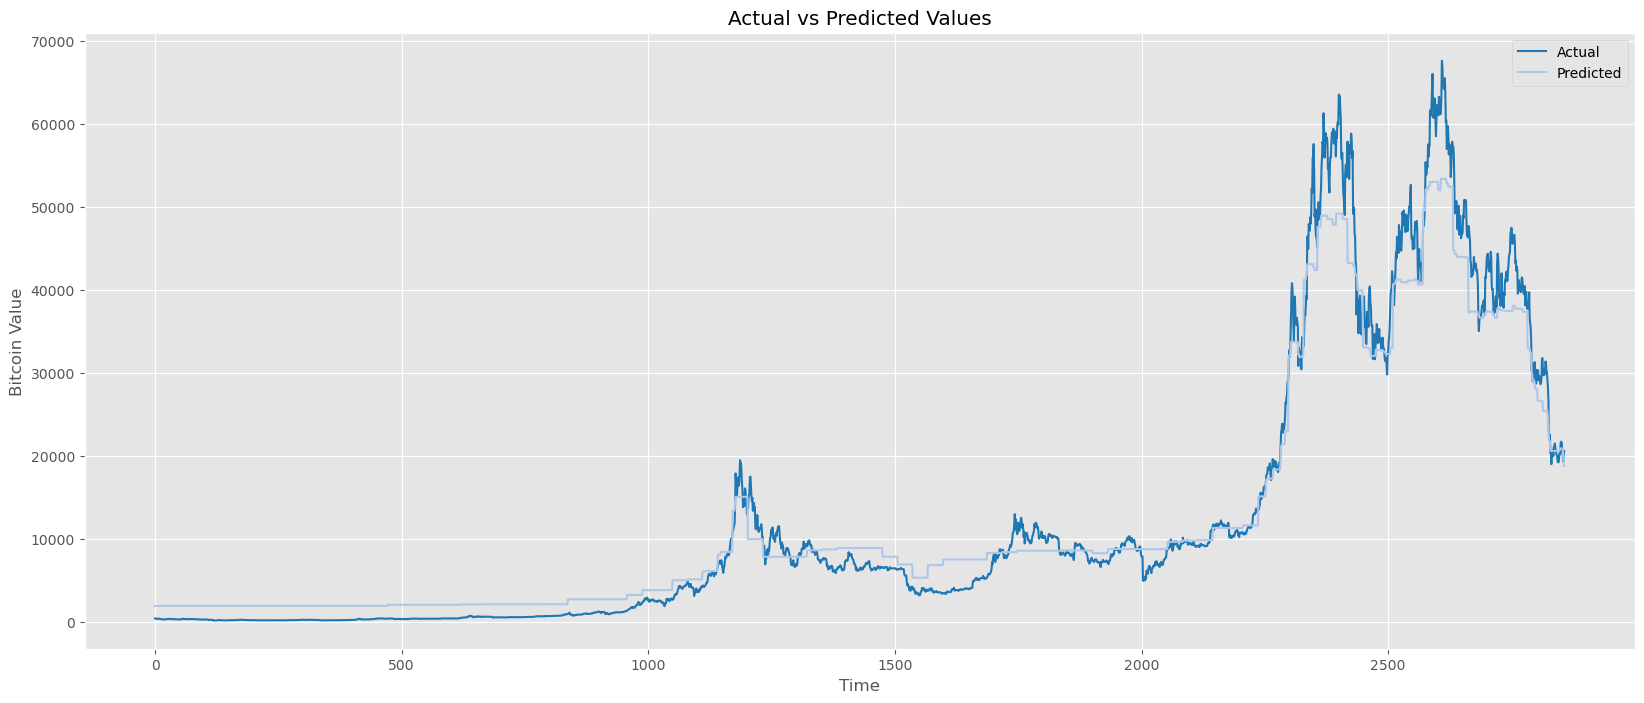

In [30]:
create_plot(train_df[target_variable], trainPredictions)

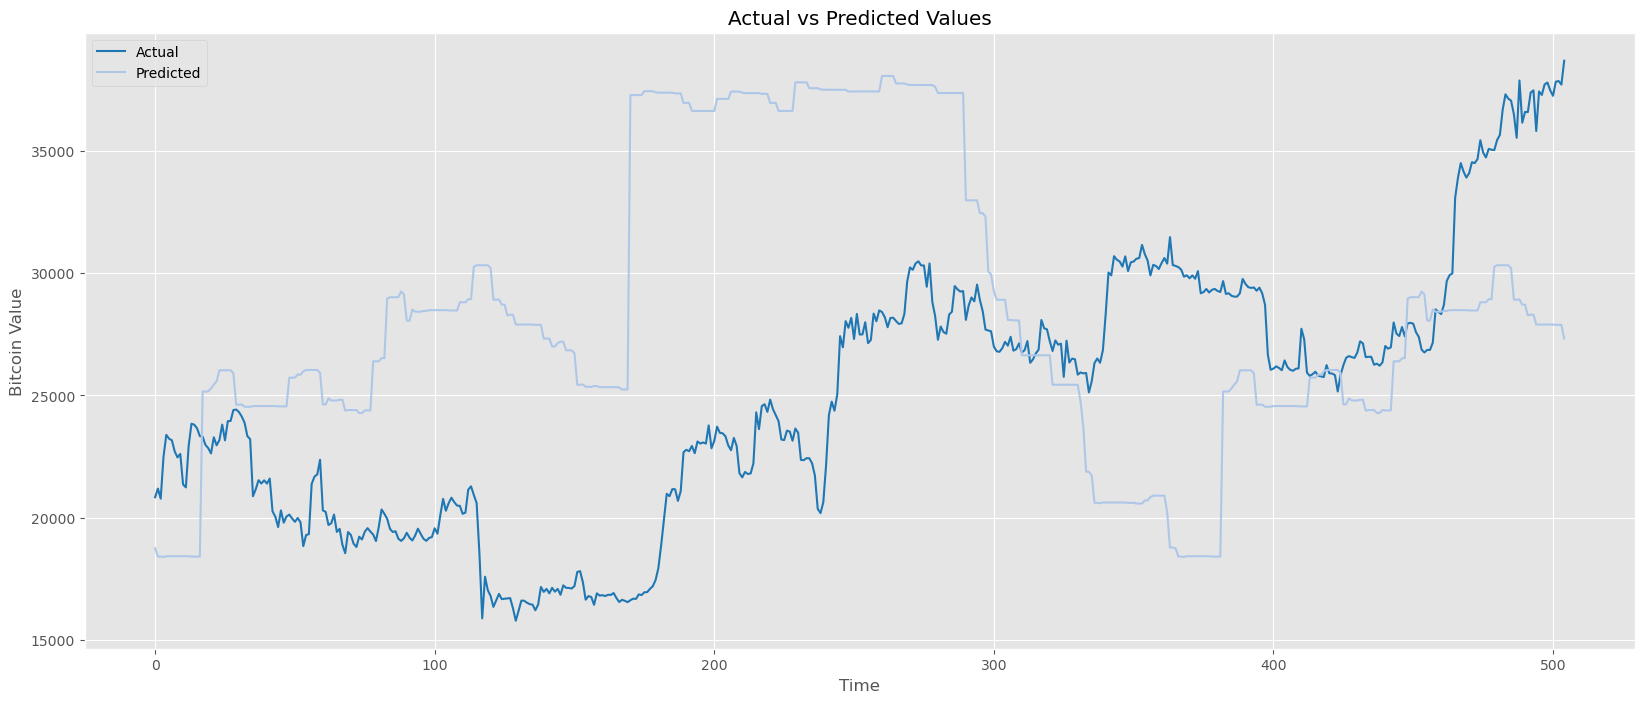

In [31]:
create_plot(test_df['Close'], testPredictions)

In [32]:
# calculate predictin metrics
gb_metrics = calculate_forecast_metrics(test_df.dropna(), actual_col='Close', benchmark_cols=['gboosting_prediction'])
gb_metrics.T

MAE           MSE         RMSE       MAPE   
gboosting_prediction  7422.246569  7.865986e+07  8869.039299  32.770634  \

                            R2  
gboosting_prediction -1.724269

## Jump Diffusion
BoxCox not useful

5 largest positive single day moves  [0.5916, 0.2681, 0.2306, 0.2222, 0.2027]
5 largest negative single day moves [-0.2016, -0.1931, -0.1662, -0.1579, -0.1539]
The probability of jump is 0.059 %


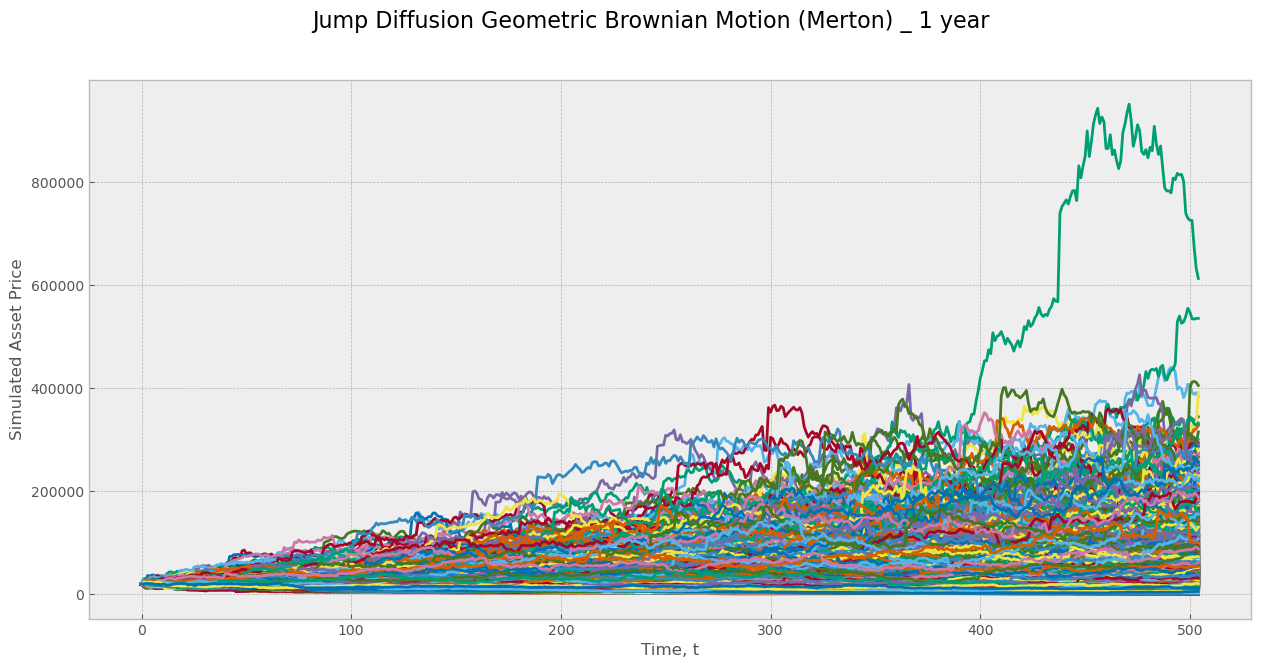

In [33]:
#create mertons jump diffusion model and simulate possible future pathes (default )
mp, jump_diffusion_examples = merton_jump_diffusion(train_df,'Close',len(test_df))

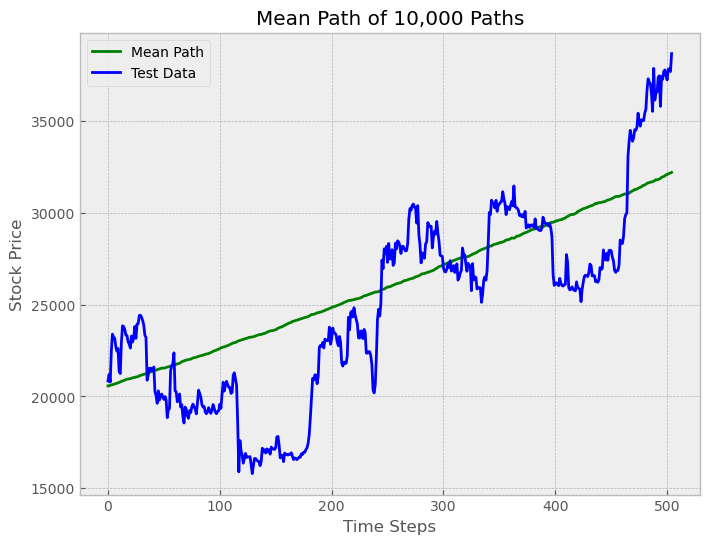

R-squared score: 0.5714596492133994


In [34]:
#avg path of all the simulated pathes compared to the test data 
mean_path = plot_avg_train(jump_diffusion_examples, test_df, 'Close',len(test_df))

In [35]:
test_df['jd_prediction'] = mean_path

In [36]:
#calculate metrics for predictions with the mean_path
diffusion_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=['jd_prediction'])
diffusion_metrics.T

MAE           MSE         RMSE       MAPE       R2
jd_prediction  2904.320721  1.237357e+07  3517.607924  13.120822  0.57146

## GAM

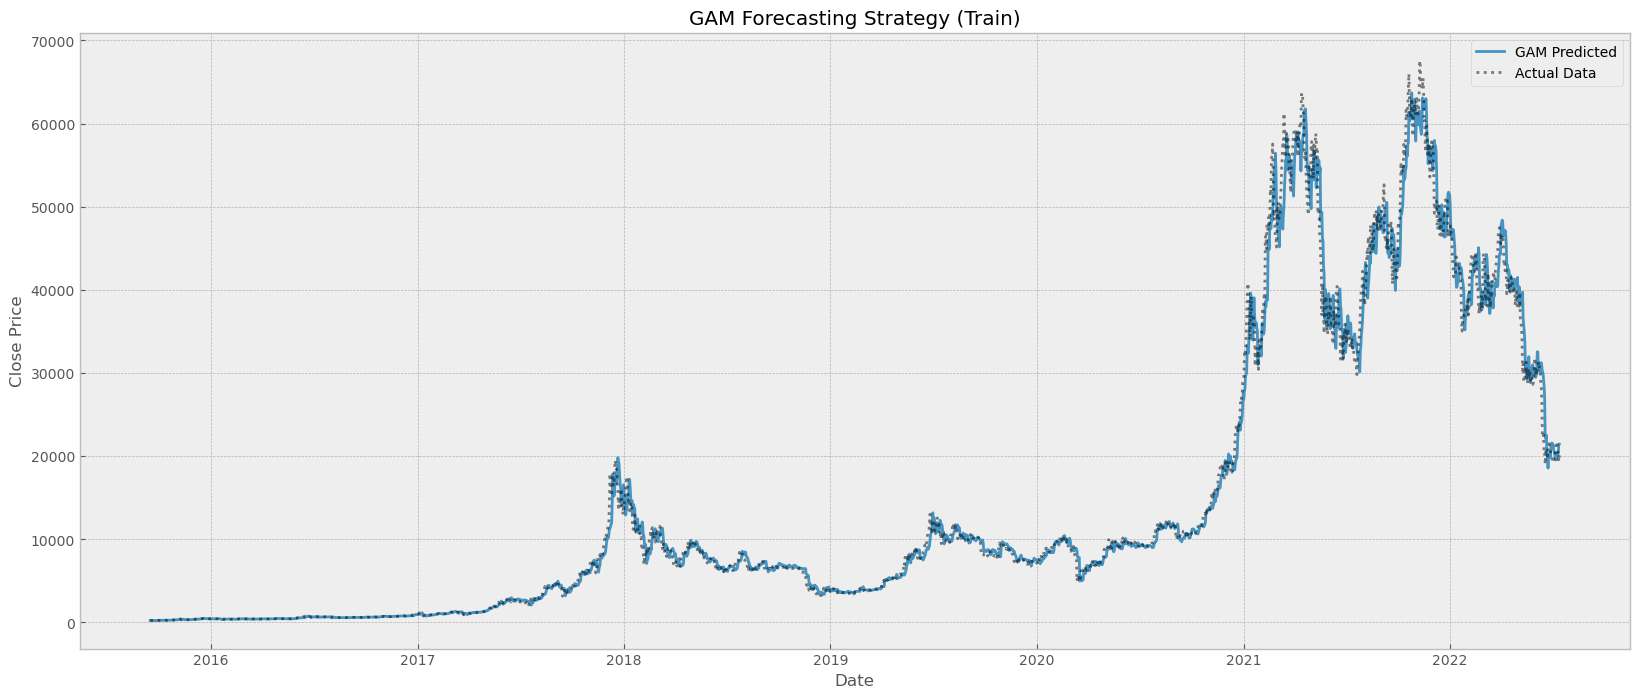

In [37]:
def strategy_gam_forecasting(df, n_days, features, target='Close', gam_model=None, trade_freq='1D'):
    """
    Fit a GAM model to the data or use an existing model to make predictions.

    :param df: DataFrame containing the data.
    :param n_days: Number of previous days to consider as a feature.
    :param target: The target variable name. Default is 'Close'.
    :param gam_model: An existing GAM model. If None, a new model will be trained.
    :return: DataFrame with predictions and the GAM model.
    """
    df = df.asfreq(trade_freq)
    df_copy = df.copy()

    # Convert date column to datetime and extract date features
    #df_copy['date'] = pd.to_datetime(df_copy['date'])
    #df_copy['year'] = df_copy['date'].dt.year
    #df_copy['month'] = df_copy['date'].dt.month
    #df_copy['day'] = df_copy['date'].dt.day
    #df_copy['weekday'] = df_copy['date'].dt.weekday

    # Add lagged values of the target variable
    df_copy[f'lag_{n_days}'] = df_copy[target].shift(n_days)
    
    # Prepare the feature matrix and target vector
    features.append(f'lag_{n_days}')
    df_copy = df_copy.dropna()
    X = df_copy[features]  # Dropping rows with NA values due to lagging
    y = df_copy[target]
    
    # Fit the model if not provided
    if gam_model is None:
        # Dynamically generate the spline terms for each feature
        gam_model = LinearGAM(s(1) + s(2) + s(3) + s(4)).fit(X, y)  #+S($)

    # Make predictions
    predictions = gam_model.predict(X)
    
    if target != 'Close':
        predictions = inv_boxcox(predictions, lambda_optimal)

    # Calculate strategy returns
    df_copy['gam_prediction'] = predictions

    return df_copy, gam_model, predictions

train_df, gam_model, predictions = strategy_gam_forecasting(train_df, n_days=5, features=['year', 'month', 'day', 'weekday'], target = 'transf')

#train_df, gam_model, predictions = strategy_gam_forecasting(train_df, features=['year', 'month', 'day', 'weekday', 'Open', 'High', 'Low'])

plt.plot(train_df.index, predictions, label=f'GAM Predicted', alpha=0.9)

plt.plot(train_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'GAM Forecasting Strategy (Train)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [38]:
gam_model.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.0069
Link Function:                     IdentityLink Log Likelihood:                                -31645.8084
Number of Samples:                         2493 AIC:                                            63387.6306
                                                AICc:                                           63389.5559
                                                GCV:                                                0.0334
                                                Scale:                                              0.0323
                                                Pseudo R-Squared:                                   0.9966
Feature Function                  Lam

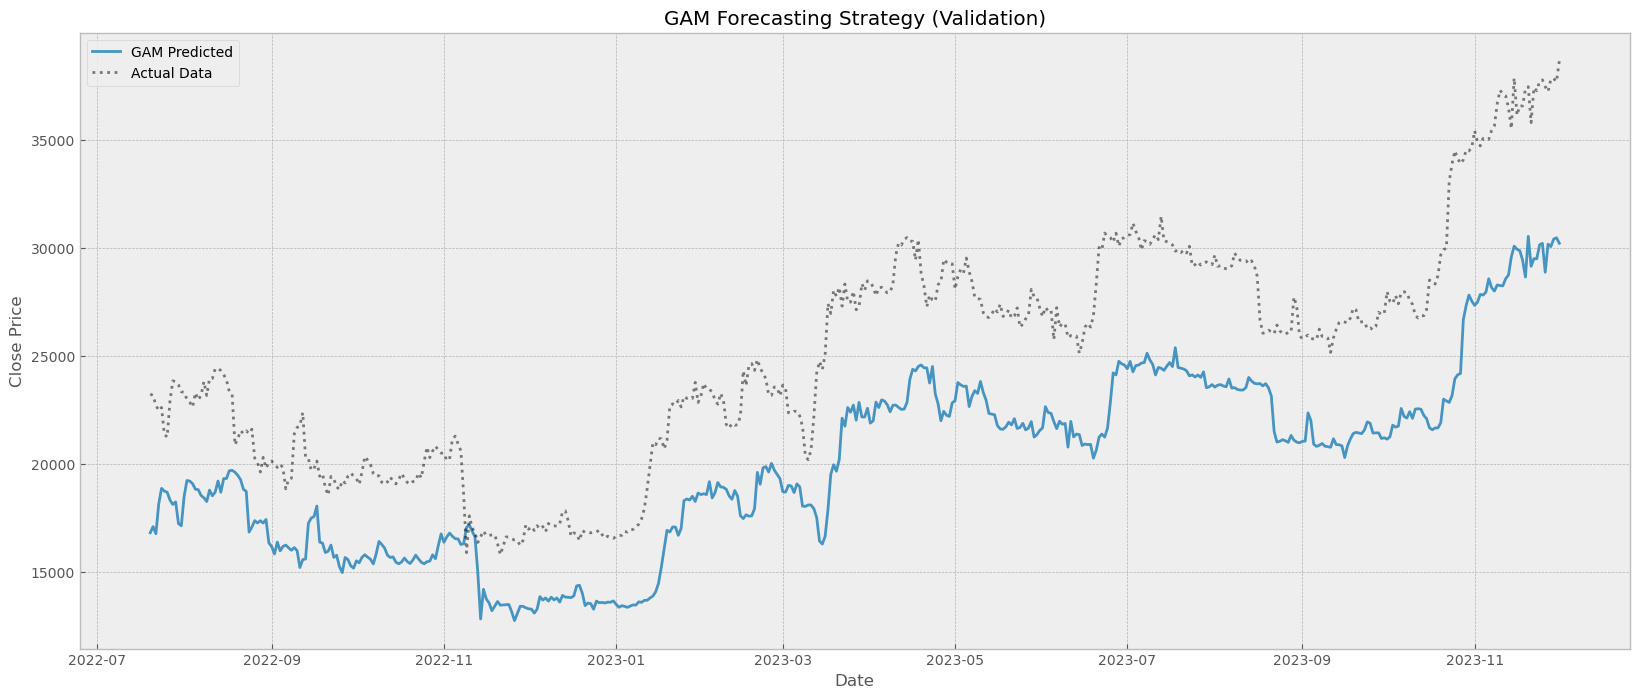

In [39]:
test_df, _, predictions = strategy_gam_forecasting(test_df, n_days=5, features=['year', 'month', 'day', 'weekday'], gam_model=gam_model)

plt.plot(test_df.index, predictions, label=f'GAM Predicted', alpha=0.9)


plt.plot(test_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
#plt.plot(val_df['lag_5'], label='Lag 5 ', color='red', alpha=0.5, linestyle='dotted')
plt.title(f'GAM Forecasting Strategy (Validation)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [40]:
#metrics for gam predictions
gam_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=['gam_prediction'])
gam_metrics.T

MAE           MSE        RMSE      MAPE        R2
gam_prediction  4966.979445  2.745715e+07  5239.95737  19.70875  0.054806

# Result 

In [41]:
#combine all the mtrics
all_metrics_df = pd.concat([diffusion_metrics.T,gb_metrics.T,gam_metrics.T,arima_metrics.T,benchmark_metrics.T, arimax_metrics.T],axis=0)

In [42]:
sorted_df = all_metrics_df.sort_values(by='MSE')
sorted_df.head(20)

MAE           MSE         RMSE       MAPE   
jd_prediction          2904.320721  1.237357e+07  3517.607924  13.120822  \
arimax_prediction      3364.390961  1.759863e+07  4195.072128  15.502013   
gam_prediction         4966.979445  2.745715e+07  5239.957370  19.708750   
bench_drift_Close      4259.440336  2.769475e+07  5262.579713  16.324904   
arima3_1_0_prediction  5551.118261  4.761991e+07  6900.717792  20.416673   
arima3_1_1_prediction  5551.135243  4.762020e+07  6900.739054  20.416722   
arima1_1_3_prediction  5552.006300  4.763591e+07  6901.877103  20.419154   
arima0_1_3_prediction  5552.128618  4.763819e+07  6902.042687  20.419486   
arima0_1_2_prediction  5555.576444  4.770107e+07  6906.596149  20.429039   
arima2_1_0_prediction  5555.834507  4.770574e+07  6906.934289  20.429758   
arima2_1_1_prediction  5558.658884  4.775253e+07  6910.320290  20.438141   
arima0_1_0_prediction  5562.778895  4.783143e+07  6916.026724  20.449146   
bench_naive_Close      5562.778895  4.783143e+07  6916.026724  20.449146   
arima1_1_1_prediction  5564.490768  4.786240e+07  6918.265572  20.453934   
arima1_1_0_prediction  5566.181707  4.789305e+07  6920.480595  20.458659   
arima0_1_1_prediction  5566.296820  4.789514e+07  6920.631702  20.458980   
arima2_0_3_prediction  5706.566770  5.046171e+07  7103.640864  20.916991   
arima3_0_2_prediction  5734.649603  5.098640e+07  7140.476468  21.007942   
arima3_0_3_prediction  5806.214910  5.232786e+07  7233.799987  21.235478   
arima1_1_2_prediction  6247.337040  6.099576e+07  7809.978170  22.484260   

                             R2  
jd_prediction          0.571460  
arimax_prediction      0.390497  
gam_prediction         0.054806  
bench_drift_Close      0.040833  
arima3_1_0_prediction -0.649246  
arima3_1_1_prediction -0.649256  
arima1_1_3_prediction -0.649800  
arima0_1_3_prediction -0.649879  
arima0_1_2_prediction -0.652057  
arima2_1_0_prediction -0.652219  
arima2_1_1_prediction -0.653839  
arima0_1_0_prediction -0.656571  
bench_naive_Close     -0.656571  
arima1_1_1_prediction -0.657644  
arima1_1_0_prediction -0.658706  
arima0_1_1_prediction -0.658778  
arima2_0_3_prediction -0.747668  
arima3_0_2_prediction -0.765840  
arima3_0_3_prediction -0.812299  
arima1_1_2_prediction -1.112499